In [ ]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image, ImageDraw
import torch
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms
import torchvision.transforms.functional as TF
from skimage.filters import threshold_otsu
import os.path as osp
import json
import random
from imgaug import augmenters as iaa

# confirm GPU is available 
ngpu = tf.config.list_physical_devices('GPU')
print("Number of GPUs avaliable:", len(ngpu))

Number of GPUs avaliable: 1


In [ ]:
# link to dataset on drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
root = '/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/' 
fine_height = 128
fine_width = 128
data_list = "train_pairs.txt"
model_path = '/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_img/'
garment_path = '/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_color/'
transform = transforms.Compose([transforms.Resize((fine_height, fine_height)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_input = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
loader = transforms.Compose([transforms.Resize((256, 192)), transforms.ToTensor()])

Text(0.5, 1.0, 'Input Garment')

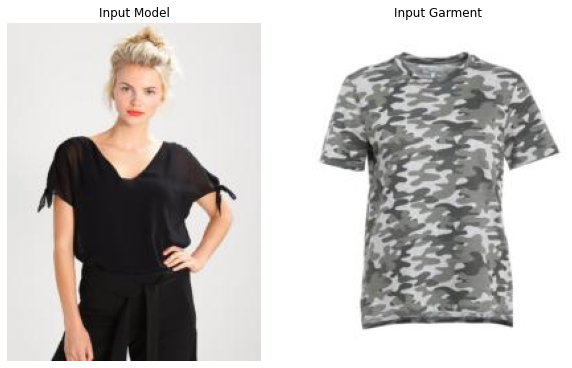

In [ ]:
fig1 = plt.figure(figsize = (10, 10))   # height and width in inches of the figure
rows = 1
columns = 2

fig1.add_subplot(rows, columns, 1)
model1 = cv2.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_img/000021_0.jpg')
plt.imshow(cv2.cvtColor(model1, cv2.COLOR_BGR2RGB))   # coverting bgr to rgb
plt.axis('off')
plt.title("Input Model")

fig1.add_subplot(rows, columns, 2)
garment1 = cv2.imread('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_color/000004_1.jpg')
plt.imshow(cv2.cvtColor(garment1, cv2.COLOR_BGR2RGB))   # coverting bgr to rgb
plt.axis('off')
plt.title("Input Garment")

In [ ]:
im_names = []
c_names = []
with open(osp.join(root, data_list), 'r') as f:
  for line in f.readlines():
    im_name, c_name = line.strip().split()
    im_names.append(im_name)
    c_names.append(c_name)




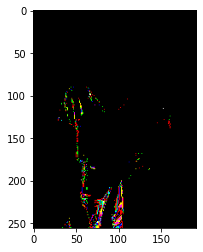

In [ ]:
# load parsing image
model1_png = Image.open('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_img/000021_0.jpg')
model1_png.save(r'/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_img/000003_0.png')
parse_array = np.array(model1_png)
# parse_shape = (parse_array > 0).astype(np.float32)
garment1_parse = (parse_array == 5).astype(np.float32) + (parse_array == 6).astype(np.float32) + (parse_array == 7).astype(np.float32) + (parse_array == 9).astype(np.float32) + \
                  (parse_array == 15).astype(np.float32) + (parse_array == 3).astype(np.float32) + (parse_array == 14).astype(np.float32)

garment1_parse_rgb = cv2.cvtColor(garment1_parse, cv2.COLOR_BGR2RGB)		# this converts it into RGB
plt.imshow(garment1_parse_rgb)
plt.show()

# load image, return cuda tensor
garment1_image = Image.fromarray(np.uint8(garment1_parse))
garment1_image = loader(garment1_image).float()
better_contrast = garment1_image.permute(1, 2, 0).detach().cpu().numpy()
better_contrast[better_contrast > 1] = 1

In [ ]:
pose_name = os.path.basename('/content/drive/MyDrive/GAN_Project/VITON_Dataset/TrainData/train_img/000021_0.jpg')
pose_name = pose_name.replace('.jpg', '_keypoints.json')
with open(osp.join(root, 'train_pose', pose_name), 'r') as i:
  pose_label = json.load(i)
  pose_data = pose_label['people'][0]['pose_keypoints']
  pose_data = np.array(pose_data)
  pose_data = pose_data.reshape((-1, 3))

In [ ]:
point_num = pose_data.shape[0]
r = 7     # self.radius
# pdb.set_trace()
coop = {}
coop2 = {}
ai = 0

# leaving out head; hip and hands are kept
for lol, i in enumerate([1, 2, 3, 4, 5, 6, 7, 8, 11]):
  pointx = pose_data[i, 0]
  pointy = pose_data[i, 1]
  if pointx > 1 and pointy > 1:
    coop[ai] = (pointx, pointy)
    coop2[ai] = (pointx, pointy)
    ai = ai + 1
  else:
    coop2[ai] = (pointx, pointy)
    ai = ai + 1

In [ ]:
# creating skeleton
bone_list = [[x[0], x[1]] for key, x in coop2.items()]
# bone_list = bone_list.numpy()
bone_list = np.array(bone_list) - 1
itemindex = np.where(bone_list == -1)
if len(itemindex[0]) == 0:
  it = 100
else:
  it = np.unique(itemindex[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'> torch.Size([256, 256, 3])


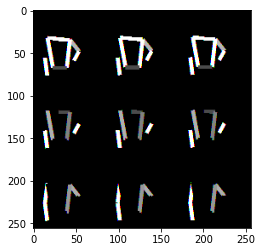

In [ ]:
one_map = Image.new('RGB', (256, 256))
draw = ImageDraw.Draw(one_map)
if np.logical_not(np.isin(it, 0)).all() and np.logical_not(np.isin(it, 1)).all():
  draw.line((bone_list[0][0], bone_list[0][1], bone_list[1][0], bone_list[1][1]), fill='red', width = 14)
if np.logical_not(np.isin(it, 1)).all() and np.logical_not(np.isin(it, 2)).all():
  draw.line((bone_list[1][0], bone_list[1][1], bone_list[2][0], bone_list[2][1]), fill='blue', width = 14)
if np.logical_not(np.isin(it, 3)).all() and np.logical_not(np.isin(it, 2)).all():
  draw.line((bone_list[2][0], bone_list[2][1], bone_list[3][0], bone_list[3][1]), fill='white', width = 14)
if np.logical_not(np.isin(it, 0)).all() and np.logical_not(np.isin(it, 4)).all():
  draw.line((bone_list[0][0], bone_list[0][1], bone_list[4][0], bone_list[4][1]), fill='orange', width = 14)
if np.logical_not(np.isin(it, 4)).all() and np.logical_not(np.isin(it, 5)).all():
  draw.line((bone_list[4][0], bone_list[4][1], bone_list[5][0], bone_list[5][1]), fill='orchid', width = 14)
if np.logical_not(np.isin(it, 6)).all() and np.logical_not(np.isin(it, 5)).all():
  draw.line((bone_list[5][0], bone_list[5][1], bone_list[6][0], bone_list[6][1]), fill='yellow', width = 14)
if np.logical_not(np.isin(it, 0)).all() and np.logical_not(np.isin(it, 1)).all():
  draw.line((bone_list[1][0], bone_list[1][1], bone_list[7][0], bone_list[7][1]), fill='gold', width = 14)
if np.logical_not(np.isin(it, 4)).all() and np.logical_not(np.isin(it, 8)).all():
  draw.line((bone_list[4][0], bone_list[4][1], bone_list[8][0], bone_list[8][1]), fill='pink', width = 14)
if np.logical_not(np.isin(it, 7)).all() and np.logical_not(np.isin(it, 8)).all():
  draw.line((bone_list[7][0], bone_list[7][1], bone_list[8][0], bone_list[8][1]), fill='brown', width = 14)

skel = one_map
resize = transforms.Resize(size=(256, 256))
skel = resize(skel)  # skeleton
skel = TF.to_tensor(skel) # transform to tensor
skel = TF.normalize(skel, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
skel = skel.view(skel.shape[2], skel.shape[1], skel.shape[0])
print(type(skel), skel.shape)
plt.imshow(skel)
plt.show()

In [ ]:
def get_binary_from_img(image_name):
  loader2 = transforms.Compose([transforms.Resize((256, 192)), transforms.ToTensor()])
  image = Image.fromarray(np.uint8(image_name))
  image = loader2(image).float()
  better_contrast = image.permute(1, 2, 0).detach().cpu().numpy()
  better_contrast[better_contrast > 1] = 1
  thresh = threshold_otsu(better_contrast)
  binary = better_contrast > thresh
  print(type(binary))
  return binary

pcm = get_binary_from_img(garment1_parse)

<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (256, 192, 3) looks like an RGB image
  import sys


In [ ]:
source = model1_png * pcm
source[source == 0] = 255
def __getitem__(self, index):
  c_name = c_names[index]
  im_name = im_names[index]
  # person image
  im = plt.imread(osp.join(model_path, 'image', im_name))
  cm = plt.imread(osp.join(model_path, 'cloth', c_name))
  return im_name
  mask = plt.imread(osp.join(model_path, 'nested_unet_msk', im_name))
  lol = get_binary_from_img(osp.join(model_path, 'nested_unet_msk', im_name))
  lol2 = source * (1 - lol)
  lol2[lol2 == 0] = 255

  lol3 = source * (lol)
  lol3[lol3 == 0] = 255

  input = Image.fromarray(np.uint8(lol2))
  mask = Image.fromarray(np.uint8(mask))
  style = Image.fromarray(np.uint8(lol3))
  target = Image.fromarray(np.uint8(source))
  cloth = Image.fromarray(np.uint8(garment1_image))

# source = transform_input(input)  # [-1,1]
  mask = transform(mask)  # [-1,1]
  style_ = transform(style)
  cloth = transform(cloth)
  targ = transform(style)

In [ ]:
class ImgAugTransformStitching:
  def __init__(self):
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    self.aug = iaa.Sequential([iaa.Scale((128, 128)), iaa.Sometimes(0.25, iaa.GaussianBlur(sigma = (0, 3.0))), iaa.Fliplr(0.5), iaa.Affine(rotate = 20 , mode='symmetric'), 
    iaa.Sometimes(0.25, iaa.OneOf([iaa.Dropout(p=(0, 0.1)), iaa.CoarseDropout(0.1, size_percent=0.5)])), iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True),
    iaa.Affine(translate_percent={"x":0.2, "y": 0.1}, rotate=(-45, 45), shear=(-16, 16), order=[0, 1], cval=(0, 255), mode='symmetric')])
  def __call__(self, img, img1, img2):
    img = np.array(img)
    img1 = np.array(img1)
    img2 = np.array(img2)
    return self.aug.augment_image(img), self.aug.augment_image(img1), self.aug.augment_image(img2)

In [ ]:
def transformData(src, target, skel):
  # Resize
  resize = transforms.Resize(size=(128, 128))
  src = resize(src)  # Source with missing cloth
  # mask = resize(mask) # mask of the missing cloth
  target = resize(target)  # target/ Ground truth
  # cloth = resize(cloth) # Cloth ground truth, how it should look before applying
  skel = resize(skel)  # skeleton

  if random.random() > 0.5:
    src, target, skel = ImgAugTransformStitching(src, target, skel)

  # Transform to tensor
  src = TF.to_tensor(src)
  target = TF.to_tensor(target)
  skel = TF.to_tensor(skel)
  src = TF.normalize(src, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  target = TF.normalize(target, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  skel = TF.normalize(skel, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  return src, target, skel

# skel = transform_input(one_map)
  source, target, skel = transformData(input, target, one_map)
  print(src, target, skel)
  del lol3, lol2, pcm, model1, garment1_parse, model1_png, lol

In [ ]:
# Number of workers for dataloader
#workers = 2

# Batch size during training
#batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer
#image_size = 64

# Number of channels in the training images. For color images this is 3
#nc = 3

# Size of z latent vector (i.e. size of generator input)
#nz = 100

# Number of training epochs
#epochs = 5

# Learning rate for optimizers
#lr = 0.0002

# Beta1 hyperparam for Adam optimizers
#beta1 = 0.5